# Linear Regression: A foray into machine Learning
by Michael Silverstein | [msilvers@broadinstitute.org](mailto:msilvers@broadinstitute.org)
| [https://github.com/michaelsilverstein/](https://github.com/michaelsilverstein/)
## Introduction
While a relatively simple concept, linear regression, or fitting a line to a set of data, serves as a great conduit to a far more complex idea: machine learning. Here I outline how to generate a noisy-linear data set, learn features from that data set, and predict a line of best fit through that dataset in hopes of recovering the original linear relationship. My hope is that this notebook will be accessible enough for anyone who is interested to read it, but rigorous enough to fully flesh out the concepts and that you'll learn:
1. How to generate your own noisy linear data set
2. The concepts of features, parameters, and observations
3. How to generate a model and visualize it

The main motivation for this notebook came from [this](http://www.deeplearningbook.org/contents/ml.html) chapter of Deep Learning by Ian Goodfellow, et. al.

# Data generation
Since our task is to perform a linear regression, we want to generate a linear-ish data set. I really mean by 'linear-ish' is a dataset that has a linear relationship that is distorted by noise. This is typically what we would observe in a natural setting. For example, imagine we are measuring the linear relationship between how much we exercise and how much we eat:

On one day we exercise for 1 hour and eat one cheeseburger, another day we exercise for 2 hours and eat 2 cheeseburgers, another day we exercise for 3 hours and eat 3 cheeseburgers, and we keep on going until we fulfill the American dream. Now imagine one day we execrcise for 2 hours and we 1.8 cheeseburgers, while this deviates a bit from our 1:1 hour-to-cheeseburger ratio, we can still feel confident about our assertion that a linear relationship exists between hours of exercise and cheeseburgers and to predict that we would eat 2 cheeseburgers after exercising for 2 hours.

**Our whole goal is to be able to predict how hungry we will be after a certain amount of exercise.**

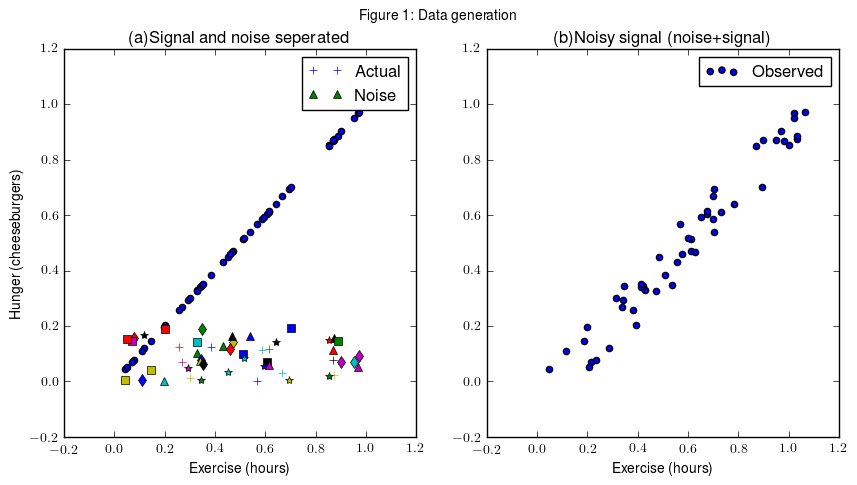

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import itertools

##Generate data
size = 50 #Number of observations
dim = 1 #Dimensionality: # of features 
jitter = .2 #Spread parameter of noise
seed = np.random.rand(size) #Linear relationship in dim dimensions
noise = np.random.rand(size) * jitter
x = seed+noise #Add noise to signal
y = seed #Now x has some deviation from the seed, when paired with the seed it will create a noisy-line

##Plotting
matplotlib.rcParams['figure.figsize'] = (10,5)
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"] #For Latex later on

markers = itertools.cycle(['+','^','s','*','d']) #Cycle through andom markers for plotting noise
fig,axs = plt.subplots(ncols=2,sharex=True)

#Signal and noise seperated
axs[0].scatter(seed,seed,label='Actual')
for p,q in zip(seed,noise):
    axs[0].plot(p,q,ls='',marker=markers.next())
axs[0].set_title('(a)Signal and noise seperated')
axs[0].set_xlabel('Exercise (hours)')
axs[0].set_ylabel('Hunger (cheeseburgers)')
axs[0].legend(['Actual','Noise'])

#Signal and noise together
axs[1].scatter(x,y,label='Observed')
axs[1].set_xlabel('Exercise (hours)')
# axs[1].plot(seed,y,':',label='Actual',c='black')
axs[1].set_title('(b)Noisy signal (noise+signal)')
axs[1].legend()

fig.suptitle('Figure 1: Data generation')
plt.show()

**Figure 1**: (a) Plots of linear relationship and noise separated and then (b) summed together to produced the _observed_ signal.

## Generating data in _n_ dimensions
So, now that we have some noisy data, we want to try and learn the 'parameters' of this data so that we can try and recover the underlying relationship. In this example we have one **feature** (Exercise) so we want to learn a **parameter** that describes a mapping from our feature space (how much we exercise) to our **observation**, how many cheeseburgers we will eat. If 1 hour of exercise leads to 1 cheeseburger, we could say the value of this parameter is 1; if 1 hour of exercise leads to 2 cheeseburgers, this parameter is 2. With one feature, this parameter in a linear relationship is the **slope** of the line. In addition to this one parameter, there is also some **bias**, or what we predict without any input. In our analogy, the bias would be how many cheeseburgers we can expect someone to eat without any exercise. We can represent our model so far as:


  Feature | Observation | Parameter | Bias 
----------|-------------|-----------|----------
 Exercise |    Hunger   |To be calc |To be calc  


For those of you familiar with the formula for a line, this parameter and bias term can be represented by: $$y = m \boldsymbol{x} + b$$

Where $\hat{y}$ is our observation, $m$ is our parmeter (or slope), $\boldsymbol{x}$ is a vector of our features, and $b$ is our bias parameter.

For those of you who are familiar with linear algebra (otherwise, just skip this), we can condense this formula by creating a vector of parameters, $\boldsymbol{w} = [w_{1},...,w_{n},b]$ for a single feature $\boldsymbol{x} \in \mathbb{R}^{n}$. Next, if we unite our features with a 1, $\boldsymbol{\hat{x}} = [x_{1},...,x_{n},1]$, we can rewrite our calculation of a single observation as: $$y = \hat{\boldsymbol{x}}\boldsymbol{w} $$

So, for a matrix $X = [\boldsymbol{\hat{x_{1}}},...,\boldsymbol{\hat{x_{m}}}]$ with $m$ observations in $n$ dimensions, we can calculate a vector of our observations, $\boldsymbol{y}\in\mathbb{R}^{m}$ for each observation in $X$: $$\boldsymbol{y} = X \boldsymbol{w}$$

In [67]:
def datagen(dim,size):
    #Input:
    #|dim = number of features
    #|size = sample size
    #Output:
    #x: features in dimensions `dim` of size `size`
    #y: observations of size `size
    jitter = 0.3 #Spread parameter of noise
    seed = np.array([np.random.rand(size)]*dim) #Linear relationship in dim dimensions
    noise = np.random.rand(dim,size) * jitter
    x = np.vstack([seed+noise,np.ones(size)]).T #append column of ones for bias (y-intercept)
    y = seed[0] #Vector of observations
    return x,y

#Example with 5 samples and two features
x,y = datagen(2,5)
df = pd.DataFrame(data=np.vstack([x.T,y]).T,columns=['x1','x2','b','y'])
df

,x1,x2,b,y
0,0.885384,0.647694,1.0,0.625542
1,1.053502,0.890382,1.0,0.808189
2,0.633374,0.572402,1.0,0.513890
3,0.427688,0.271087,1.0,0.154687
4,0.299268,0.454555,1.0,0.281626


## Parameter estimation: Numerical method
Now we have a set of features, their 1s for bias, and the observation that results from each set of features. As a reminder, for our analogy we have one feature, amount of exercise, with an observation of hunger. Now, in order find the relationship between exercise and hunger there is a huge space of parameters (including the bias parameter, aka how many cheeseburgers we can expect to eat without any exercise) we can explore. For example, if without exercise we will eat 1 cheeseburger and if with exercise the 1 we normally eat + 2 * the number of hours we exercised, then our bias = 1 and our slope (our parameter) = 2. Aka, $y = 2x+1$. 

The 'Noisy Signal' in **Figure 1** is akin to making multiple observations of someone's hunger after different amounts of time exercising. While we have these observations and they appear to be linear, we don't know the parameters (slope of the line and y-intercept(bias)), and without the parameters we won't be able to predict how hungry this person will be after a given time of exercise. One thing we can do to find these parameters is to just guess and evaluate how well those parameters predict the observations! For a given set of parameters (slope and bias) we can draw a line and then measure how far each observation lies from that line, then we can sum up those distances to serve as a metric of how well that line predicts the data. If the sum of all of the distances is a large value, we know that our line was a bad predictor because each observation was collectively far away from the line.

This introduces the idea of a cost function: a function that describes a cost we want to avoid in making our model (line produced with parameters). In this case the cost is the distance from our line - the greater the distance the worse the prediction. Our goal in parameter estimation is to find the parameters that produce the smallest cost function.

We can formalize this task mathematically by using the mean squared error (MSE) to measure the sum of the distance from our model  to the observations:
$$MSE = \frac{1}{m}||\boldsymbol{\hat{y}} - \boldsymbol{y}||^{2}$$
For a vector of observations $\boldsymbol{y} \in \mathbb{R}^m$ and predictions $\boldsymbol{\hat{y}} \in \mathbb{R}^m$. Where the goal is: $$\boldsymbol{w}^* = argmin(MSE),$$ where $\boldsymbol{w}^*$ is the vector of parameters the produces the $\hat{y}$ that minimizes $MSE$.

So let's start by calculating the $MSE$ for a whole grid of possible parameters

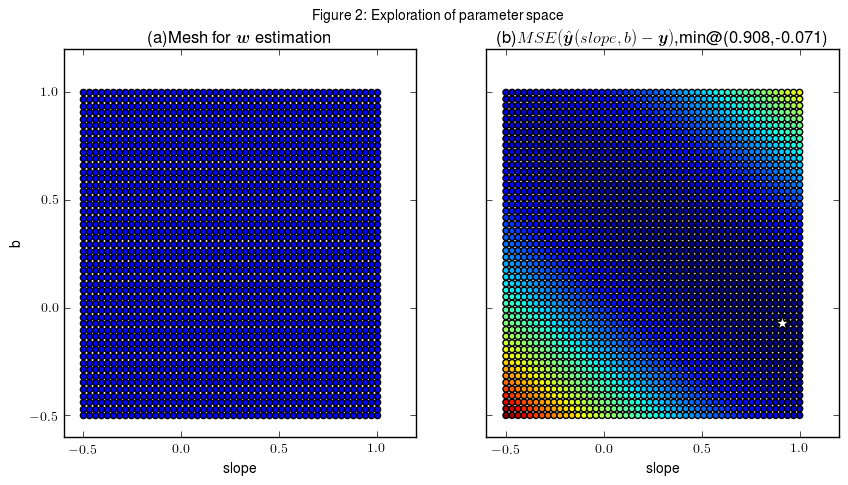

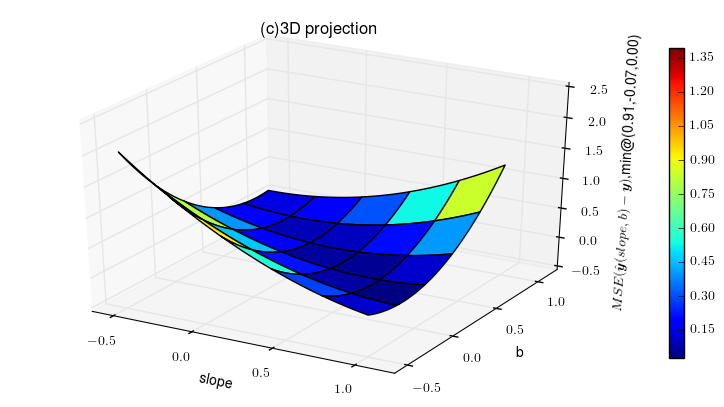

In [68]:
def MSE(y_,y):
    #Compute MSE for a vector of predictions y_ and observations y
    return 1./size*np.power(np.linalg.norm(y_-y),2)

#Generate data
dim,size = 1,50
x,y = datagen(dim,size)

#Generate mesh
amin,amax = -.5,1
seed = np.linspace(amin,amax,size)
slope,b = np.meshgrid(seed,seed) #50x50 grid from 0 to 2

combos = np.vstack([slope.ravel(),b.ravel()]) #All pairwise combinations of parameters in grid
#Compute y_hat for each set of parameters
y_tests = np.dot(x,combos).T #y_tests = [y_hats{1},...,y_hats{size}], for pairs of parameters 1,...,size
MSEs = np.array([MSE(y_,y) for y_ in y_tests]).reshape(size,size) #Calculate MSE for each set of y_hats
minval_ix = np.unravel_index(np.argmin(MSEs),(size,size)) #Find index at which MSE is the smallest
##Plot
fig,axs = plt.subplots(ncols=2,sharex=True,sharey=True)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111,projection='3d')
#Let's take a look at the meshgrid we created
axs[0].scatter(slope,b)
axs[0].set_xlabel('slope')
axs[0].set_ylabel('b')
axs[0].set_title(r'(a)Mesh for $\boldsymbol{w}$ estimation')

#Now let's project the MSE values for each pair of parameters onto the corresponding location
best_b = seed[minval_ix[0]] #Best b is at the location of our mesh where the smallest MSE exists on the b axis
best_slope = seed[minval_ix[1]] #Best slope is at the location of our mesh where the smallest MSE exists on the slope axis
axs[1].scatter(slope,b,c=MSEs)
axs[1].scatter(best_slope,best_b,marker='*',c='white',s=120,label='Minimum MSE')
axs[1].set_xlabel('slope')
axs[1].set_title(r'(b)$MSE(\hat{\boldsymbol{y}}(slope,b)-\boldsymbol{y})$,min@(%.3f,%.3f)'%(best_slope,best_b))


#Let's take another look at the MSEs per parameter pair, but now let's take a look in 3d.
surf = ax2.plot_surface(slope,b,MSEs,cmap='jet')
ax2.set_xlabel('slope')
ax2.set_ylabel('b')
best_MSE = np.min(MSEs)
ax2.set_zlabel(r'$MSE(\hat{\boldsymbol{y}}(slope,b)-\boldsymbol{y})$,min@(%.2f,%.2f,%.2f)'%(best_slope,best_b,best_MSE))
ax2.scatter(best_slope,best_b,zs=best_MSE,marker='*',c='white',s=200)
ax2.set_title('(c)3D projection')
fig2.colorbar(surf,shrink=0.8)

plt.legend()
fig.suptitle('Figure 2: Exploration of parameter space')
plt.show()

**Figure 2:** Exploring a range of values for the two parameters that describe a line - slope and bias. (a)The mesh of pairs of slopes and bias we are interested in testing. Each point represents a (slope,bias) pair, which in turn represents a line. (b)Color indicates the MSE for each (slope,bias) pair as described by the colorbar in (c), which shows the same projection but in 3D. The white star indicates the location of the minimum MSE.

## Linear Regression: Analytical method
Found it! Well at least the best approximation of our solution given the resolution of our search. That white star denotes the *optimal* set of parameters that when used produces a line that passes through all of our observations as closely as possible. After producing this grid we used `np.argmin(MSEs)` to find which pair of parameters produced the smallest MSE. This approach required us to iterate through a space of $m^2$, for sample size $m$ with a resolution of $\frac{a_{max}-a_{min}}{m}$, based on `amin` and `amax`. This means we are iteratively exploring a discrete space, which is potenitally 'dangerous' for two reasons:
1. Iterative processes can be computationally expensive
2. Discrete spaces are limited by their resolution
3. Discrete spaces require us to have some idea of the range in which the best solution lies
    * In our case, we had a fairly good idea of where in the parameter space we were looking. We had only a slightly noisy line, so we knew the slope parameter should be fairly close to 1 for example. This solution would have far more difficult to find if we didn't start off knowing which neighborhood to look in.

Ideally, we would be able to find an analytical solution to this problem. An analytical approach would allow us to find the solution directly instead of analytically, ie without iteration and on a continuous space as opposed to a discrete one. For those who are familiar with calculus you may recognize our task as a classic optimization problem: we have some function, in this case, $f(\boldsymbol{w}) = MSE(\boldsymbol{\hat{y}(w)-y})$, that we wish to find the optimal value of, in this case the global minimum. Analytically, calculus provides a very easy way to do this - an optima exist where the derivative of a function equals zero: $\frac{df}{dx} = 0$. We can extend this concept to the $MSE$ function (Deep Learning, 108):

$$\nabla_{w}MSE = 0$$
$$\Rightarrow \nabla_{w}\frac{1}{m}||\boldsymbol{\hat{y}-y}||^2 = 0$$ 
$$\Rightarrow \nabla_{w}||X\boldsymbol{w-y}|| = 0$$
$$\Rightarrow \nabla_w(X\boldsymbol{w-y})^T(X\boldsymbol{w-y})=0$$
$$\Rightarrow 2X^TX\boldsymbol{w} - 2X^T\boldsymbol{y}=0$$
$$\Rightarrow \boldsymbol{w} = (X^TX)^{-1}X^T\boldsymbol{y}$$

So there we have it, an analytical solution to find $\boldsymbol{w}$ as opposed to our previous numerical approach. Let's take a look at how to implement this solution to:
1. Analytically solve for the optimal set of paramteres $\boldsymbol{w}$
2. Use those parameters to predict $\boldsymbol{\hat{y}^{(test)}}$. We will calculate this vector the same as before, using $\boldsymbol{\hat{y}} = X\boldsymbol{w} $, but this time, the vector we calculate will be guaranteed to be from the optimal parameters, so this vector will contain the optimal prediction.

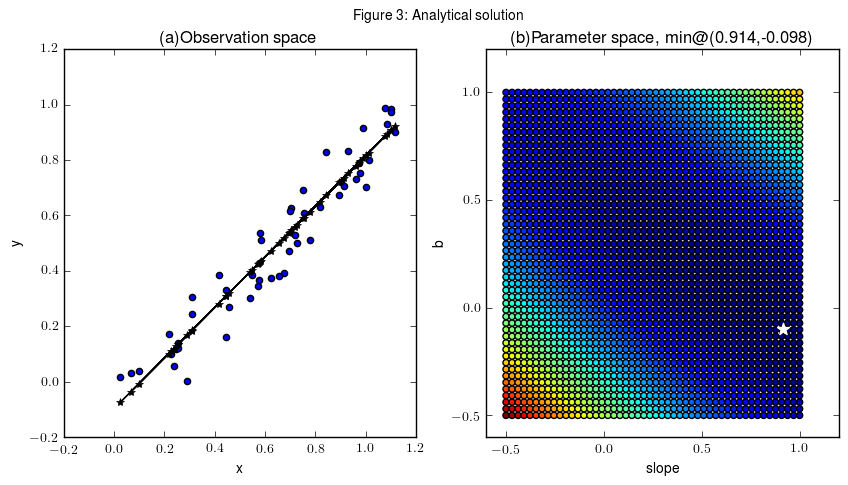

In [69]:
def linreg(x,y):
    #Train model parameters, w, based on matrix of features,x, and observations, y
    w = np.dot(
        np.dot(
            np.linalg.inv(
                np.dot(x.T,x)),
                    x.T),
                        y)
    return w
def gridsearch(size,ax=False,amin=-.5,amax=1,contour=False):
    #Find optimal parameters through a grid search with resolution sizeXsize
    #Input:
    #|size: step size between points in grid; grid resolution
    #|ax: When plot is desired, pass ax object to plot
    #|amin,amax = axis min and max
    #|contour: plot contour plot instead of scatter
    #Output:
    #|w: parameters that minimize MSE
    
    #Generate mesh
    seed = np.linspace(amin,amax,size)
    slope,b = np.meshgrid(seed,seed) #50x50 grid from 0 to 2
    combos = np.vstack([slope.ravel(),b.ravel()]) #All pairwise combinations of parameters in grid

    #Compute y_hat for each set of parameters
    y_tests = np.dot(x,combos).T #y_tests = [y_hats{1},...,y_hats{size}], for pairs of parameters 1,...,size
    MSEs = np.array([MSE(y_,y) for y_ in y_tests]).reshape(size,size) #Calculate MSE for each set of y_hats
    minval_ix = np.unravel_index(np.argmin(MSEs),(size,size)) #Find index at which MSE is the smallest

    w = [seed[minval_ix[1]],seed[minval_ix[0]]]
         
    if ax:
        if contour:
            ax.contourf(slope,b,MSEs)
        else:
            ax.scatter(slope,b,c=MSEs)
        ax.set_xlabel('slope')
        ax.set_ylabel('b')
    return w

#Generate data
dim,size = 1,50
x,y = datagen(dim,size)

##Linear regression
#Train model
w = linreg(x,y)
#Test model to predict solution
y_test = np.dot(x,w)

##Plotting
fig,axs = plt.subplots(ncols=2)

#Plot analytical solution in observation space
axs[0].scatter(x[:,0],y)
axs[0].plot(x[:,0],y_test,marker='*',c='black')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('(a)Observation space')

#Plot coordinate of parameters in feature space
gridsearch(size,ax=axs[1])
axs[1].scatter(w[0],w[1],marker='*',color='white',s=80)
axs[1].set_title('(b)Parameter space, min@(%.3f,%.3f)'%(w[0],w[1]))

fig.suptitle('Figure 3: Analytical solution')
plt.show()

**Figure 3:** (a)The best line of fit based on the parameters provided by the analyitcal solution. (b)The white star, again, indicates the location of the minimum MSE, however, this time, this location was found analytically as opposed to **Figure 2** where we had to numerically search through the parameter space for the minimum MSE.

## Comparing analytical and numerical methods
That line in Figure 3 is looking like it fits the data pretty snug. Pretty awesome right? Just a quick look at the code shows how much more direct the analytical method approach is as compared to the numerical approach, but it's power doesn't end there. Let's take a look at how much more accurate the analytical method is by seeing what resolution is required for the numerical method to find to (at least nearly) reach the solution produced by the analytical method. In **Figure 4**, resolution is shown as colors go from black to red.

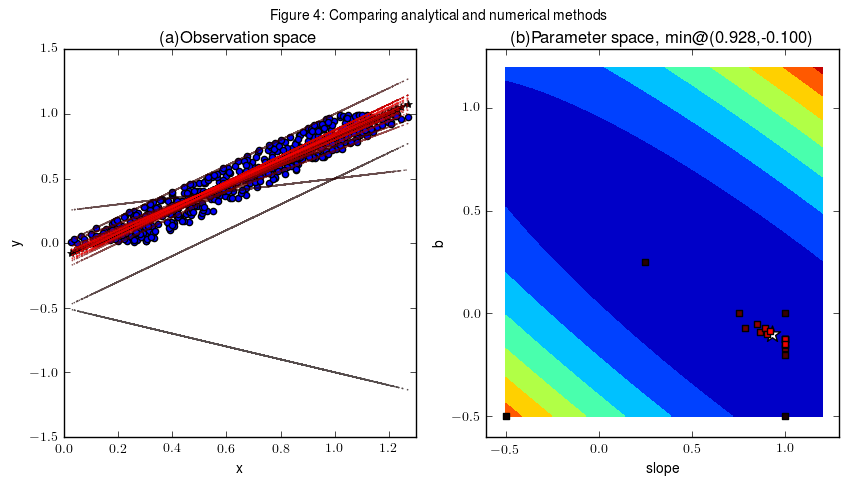

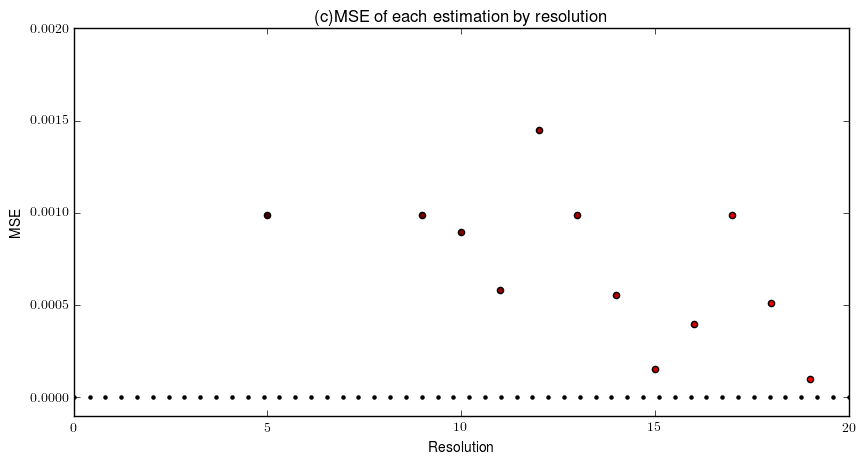

In [70]:
#Generate data
dim,size = 1,500
x,y = datagen(dim,size)

#Let's start off by calculating the analytical solution
w = linreg(x,y) #Train
y_test = np.dot(x,w) #Test

##Plotting
fig,axs = plt.subplots(ncols=2)
fig2,ax2 = plt.subplots()
ax2.set_xlabel('Resolution')
ax2.set_ylabel('MSE')
ax2.set_title('(c)MSE of each estimation by resolution')

#Initialize grid
gridsearch(50,ax=axs[1],contour=True,amax=1.2)
axs[1].set_title('(b)Parameter space, min@(%.3f,%.3f)'%(w[0],w[1]))
# axs[1].set_xlim(0) #Zoom in 

#Plot analytical solution in observation space
axs[0].scatter(x[:,0],y)
axs[0].set_xlim(0,1.3)
axs[0].plot(x[:,0],y_test,marker='*',c='black')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('(a)Observation space')

#And in Parameter space
axs[1].scatter(w[0],w[1],marker='*',c='white',s=150)

#Now that we have our optimal solution, let's see how the approximation of the solution changes as we increase 
#resolution of the grid search
max_res = 20
ax2.scatter(np.linspace(0,max_res,50),[0]*50,marker='.',c='black')#x-axis
ax2.set_xlim(0,max_res)
ax2.set_ylim(-0.0001,0.002)
grad = np.vstack([np.linspace(0,1,max_res),np.zeros([2,max_res])]).T #Color from red to black

for i in range(1,max_res):
    w_app = gridsearch(i)
    y_app = np.dot(x,w_app)
    error = MSE(y_app,y_test) #We've got this MSE function laying around, so let's use it to calulate error of our estimation!
    #Observation space
    axs[0].plot(x[:,0],y_app,':',alpha=0.7,c=grad[i])
    #Parameter space
    axs[1].scatter(w_app[0],w_app[1],marker='s',c=grad[i])
    #Error
    ax2.scatter(i,error,c=grad[i])
fig.suptitle('Figure 4: Comparing analytical and numerical methods')
plt.show()

**Figure 4:** An exploration of how our prediction accuracy changes when we increase the resolution of our search space. Colors go from black to red in each plot to represent each step increase in resolution. (a)The lines produced by the parameters estimated at each resolution of our search space. The black stars (hard to see) represent the line produced by the analytical solution. (b)The location of the minimum MSE for each grid search resolution with the white star reperesenting the location of the minimum MSE. (c)How MSE changes as resolution increases.

## Conclusion
The linear regression serves as a great starting point for understanding machine learning. It's a relatively simple model that gives you the opportunity to grasp the concepts of features, parameters, and observations as well as see the difference between numerical and analytical methods. In reality, linear relationships in nature are rare, but these basic principles provide a solid foundation for moving forward with more complicated machine learning concepts. 
Just to conclude, let's now make one more plot - the one that inspired to make this lesson in the first place from [Deep Learning pg. 109](http://www.deeplearningbook.org/contents/ml.html). This plot uses the analytical solution and shows where optimal solution lies in parameter space when we hold the bias constant. 

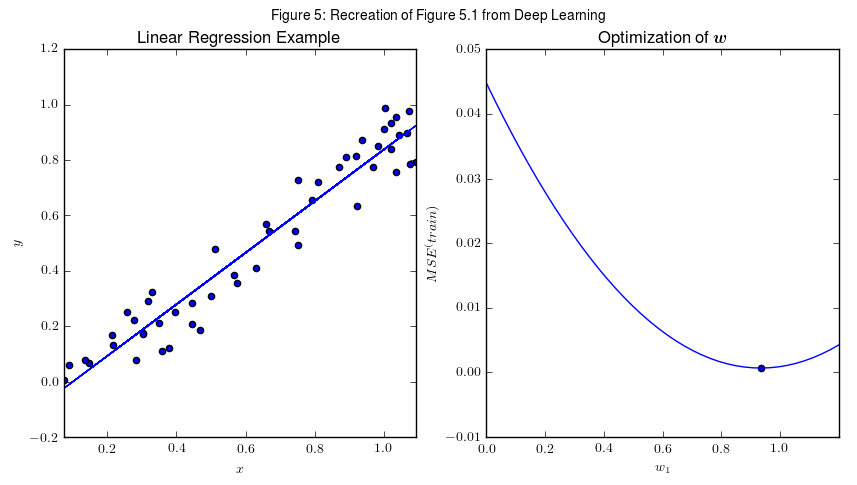

In [114]:
#Generate data
x,y = datagen(1,50)

#Train our model
w = linreg(x,y)
y_train = np.dot(x,w)

#Plot our model with observations
fig,axs = plt.subplots(ncols=2)
axs[0].scatter(x[:,0],y)
axs[0].plot(x[:,0],y_train)
axs[0].set_title('Linear Regression Example')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim(np.min(x[:,0]),np.max(x[:,0]))

#Now we know our optimal parameters, let's take a look at how MSE changes while we keep our bias parameter constant 
#and vary the slope parameter, w1
ws = np.array([[i,w[1]] for i in np.linspace(0,w[0]+.5,50)]) #Varying slope parameter while keeping bias param constant
y_trains = np.dot(x,ws.T).T
MSEs = [MSE(y_,y) for y_ in y_trains]
best_MSE = MSE(y_train,y)
axs[1].scatter(w[0],best_MSE)
axs[1].plot(ws[:,0],MSEs)
axs[1].set_xlabel('$w_{1}$')
axs[1].set_ylabel('$MSE^(train)$')
axs[1].set_xlim(0,1.2)
axs[1].set_title(r'Optimization of $\boldsymbol{w}$')

fig.suptitle('Figure 5: Recreation of Figure 5.1 from Deep Learning')
plt.show()